In [ ]:
from pytorch3d.io import load_objs_as_meshes

mesh = load_objs_as_meshes(["data/meshes/mixamo-human.obj"])

  warnings.warn("No mtl file provided")



In [163]:
import torch


meshes = mesh.extend(10)

torch.save(meshes, 'meshes.pt')

meshes_read = torch.load('meshes.pt')

In [172]:
from text3d2video.artifacts.animation_artifact import AnimationArtifact


anim = AnimationArtifact.from_wandb_artifact_tag('rumba:latest')
frame_nums = anim.frame_nums(10)

anim.load_frames(frame_nums)

  warnings.warn("No mtl file provided")



In [174]:
frame_nums = anim.frame_nums()
frames = anim.load_frames(frame_nums)

  warnings.warn("No mtl file provided")



In [177]:
torch.save(frames, 'frames.pt')

In [180]:
frames_read = torch.load('frames.pt')
frames_read[0]

(-0.9787832409143448,
 0.9787822276353836,
 -0.9546465814113617,
 0.9869105756282807)

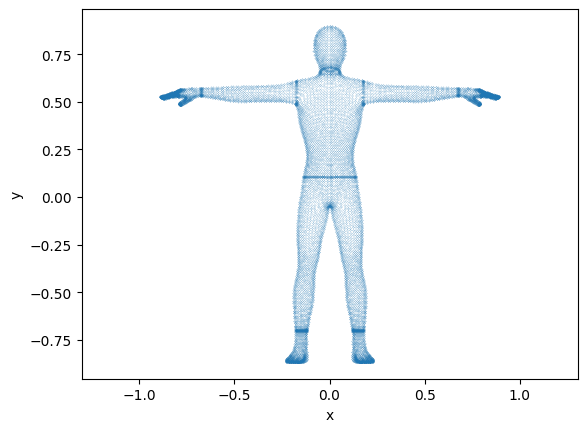

In [154]:
from matplotlib import pyplot as plt

verts = mesh.verts_list()[0]

horizontal_axes = 0
vertical_axes = 1
ax_names = ['x', 'y', 'z']

plt.scatter(verts[:, horizontal_axes], verts[:, vertical_axes], s=0.01)
plt.xlabel(ax_names[horizontal_axes])
plt.ylabel(ax_names[vertical_axes])
plt.axis('equal')

In [133]:
from torch import Tensor
from scipy.spatial.transform import Rotation

t = Tensor([0, 0, -3])
rot = Rotation.from_euler('y', 10, degrees=True)
r = Tensor(rot.as_matrix())

tensor([[ 1.,  0.,  0., -0.],
        [ 0.,  1.,  0., -0.],
        [ 0.,  0.,  1., -3.],
        [ 0.,  0.,  0.,  1.]])
tensor([ 0.,  0., -3.])
tensor([-0., -0., -3.])


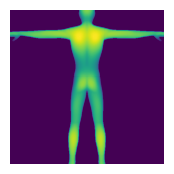

<Figure size 640x480 with 0 Axes>

In [137]:
from pytorch3d.renderer import FoVPerspectiveCameras
from torch import Tensor
from scipy.spatial.transform import Rotation
from scripts.view_animation_usd import assemble_transform_srt, decompose_transform_srt
from text3d2video.ipython_utils import display_ims
from text3d2video.rendering import render_depth_map

# camera translation/rotation (c2w)
t = Tensor([0, 0, -3])
rot = Rotation.from_euler('y', 0, degrees=True)
r = Tensor(rot.as_matrix())

# convert to world to camera
c2w = assemble_transform_srt(t, torch.ones(3), r)
w2c = c2w.inverse()

t_w2c, _, r_w2c = decompose_transform_srt(w2c)

# create camera
cam = FoVPerspectiveCameras(R=r_w2c.unsqueeze(0), T=t_w2c.T.unsqueeze(0), fov=30)

# get c2w
w2c = cam.get_world_to_view_transform()
w2c = w2c.get_matrix()[0].T
c2w = w2c.inverse()

print(c2w)

t_new, s, r = decompose_transform_srt(c2w)

print(t)
print(t_new)

meshes = mesh.extend(len(cam))
depths = render_depth_map(meshes.cuda(), cam.cuda())
display_ims(depths)

In [ ]:
t = Tensor([0, 0, -3])
rot = Rotation.from_euler("y", 20, degrees=True)
r = Tensor(rot.as_matrix())

w2c = assemble_transform_srt(t, torch.ones(3), r)

# to construct camera, pass transposed r_w2c and t_w2c
t_w2c, _, r_w2c = decompose_transform_srt(w2c)
cam = FoVPerspectiveCameras(R=r_w2c.T.unsqueeze(0), T=t_w2c.unsqueeze(0))

w2c_ = cam.get_world_to_view_transform().get_matrix()[0].T

t_w2c_, _, r_w2c_ = decompose_transform_srt(w2c_)

assert torch.allclose(t, t_w2c_)
assert torch.allclose(r, r_w2c_)

In [120]:
t = Tensor([0, 0, -3])
rot = Rotation.from_euler("y", 20, degrees=True)
r = Tensor(rot.as_matrix())

# construct c2w
c2w = assemble_transform_srt(t, torch.ones(3), r)
w2c = c2w.inverse()

# to construct camera, pass transposed r_w2c and t_w2c
t_w2c, _, r_w2c = decompose_transform_srt(w2c)
cam = FoVPerspectiveCameras(R=r_w2c.T.unsqueeze(0), T=t_w2c.unsqueeze(0))

# recover w2c
w2c_ = cam.get_world_to_view_transform().get_matrix()[0].T
c2w_ = w2c_.inverse()

t_, _, r_ = decompose_transform_srt(c2w_)

atol = 0.00001
assert torch.allclose(w2c_, w2c, atol=atol)
assert torch.allclose(c2w_, c2w, atol=atol)

assert torch.allclose(t_, t, atol=atol)
assert torch.allclose(r_, r, atol=atol)